## XAI Example notebook

###  Load Data, model

In [1]:
x_val = catalog.load('x_val')
y_val = catalog.load('y_val')
model = catalog.load('model')

2020-07-17 15:13:07,895 - kedro.io.data_catalog - INFO - Loading data from `x_val` (CSVDataSet)...
2020-07-17 15:13:08,636 - kedro.io.data_catalog - INFO - Loading data from `y_val` (CSVDataSet)...
2020-07-17 15:13:08,657 - kedro.io.data_catalog - INFO - Loading data from `model` (PickleDataSet)...


## Partial Plot
- ある特徴量とラベルの相関
- ある特徴量と予測結果の相関
- ある特徴量がどの値のときにラベルの予測結果に影響を与えているかのプロット

が見れる。
### detail usage
https://github.com/SauceCat/PDPbox/blob/master/tutorials/pdpbox_binary_classification.ipynb

In [2]:
feature_name = 'both_price'

- テストデータにおいて、feature_nameとtargetの相関を確認
- 連続値は勝手にヒストグラムに変換してくれる。

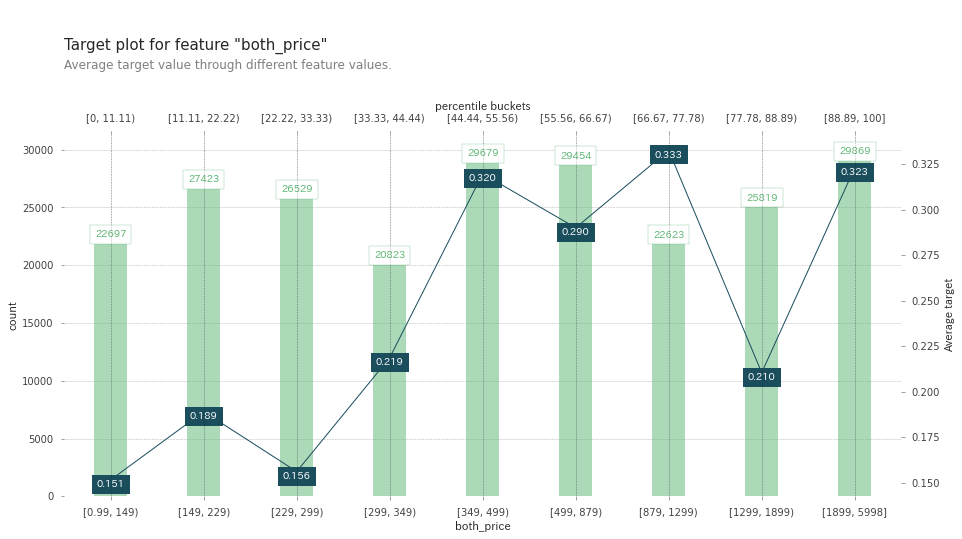

In [6]:
from pdpbox import pdp, info_plots

val_df = pd.concat([x_val, y_val], axis=1)
fig, axes, summary_df = info_plots.target_plot(
    df=val_df,
    feature=feature_name,
    # num_grid_points=200, # histogramの細かさを決める
    feature_name=feature_name,
    target='target',
    show_percentile=True
)

- テストデータにおいて、KEKKIN-maxと予測結果の相関を確認
- ラベルとの相関(↑のグラフ)ほど明確ではないが同じような傾向が見える。
- feature_nameにおいては正しく学習がなされていることがわかる

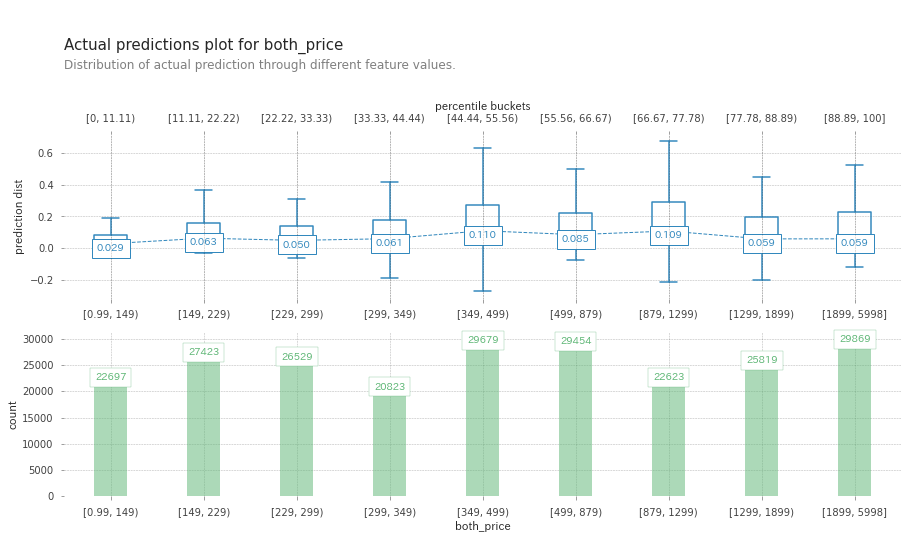

In [5]:
fig, axes, summary_df = info_plots.actual_plot(
    model=model, X=x_val, feature=feature_name, feature_name=feature_name, 
    # num_grid_points=200, # histogramの細かさを決める
    show_percentile=True, predict_kwds={},
)

- PDPを算出&プロット
- both_priceは300ぐらいまでは値が大きいほどtargetの値を下げる傾向にあるが、それ以降の影響力は一定

2020-07-17 15:15:49,886 - matplotlib.font_manager - WARNING - findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


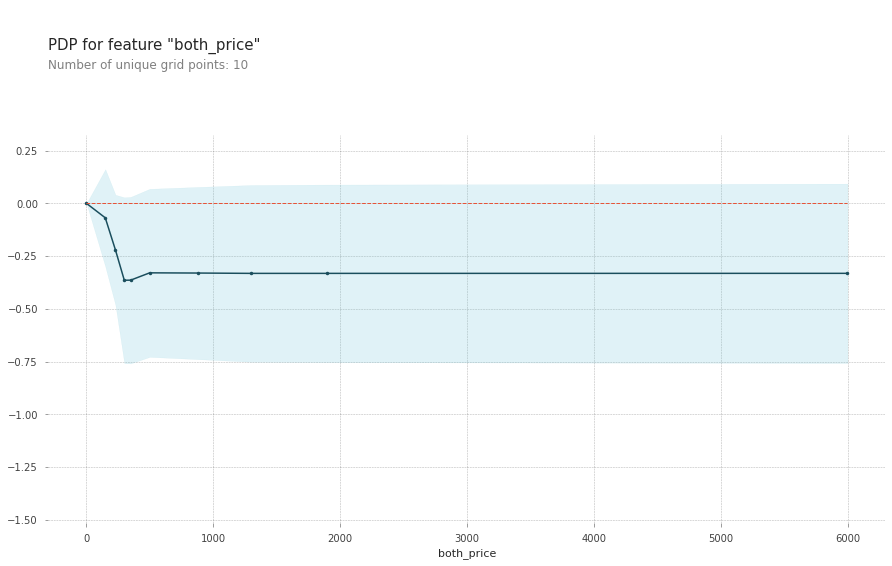

In [8]:
pdp_feat = pdp.pdp_isolate(
    model=model, dataset=val_df, model_features=x_val.columns.values, feature=feature_name
)
fig, axes = pdp.pdp_plot(pdp_feat, feature_name)

## SHAP
あるサンプルデータの予測に、どの特徴量が寄与しているかを確認

- explainerが扱う値は決定木の出力そのものなので、0~1になっていないことに注意。 
- 決定木の出力 = `model.predict(pd.DataFrame(x_val.iloc[idx, :]).T, output_margin=True)`
- 単純に確信度高くlabel=0のものほど値が小さく、逆は値が大きくなるのは同じ

In [9]:
import shap
shap.initjs()
idx = np.random.choice(len(x_val))

In [10]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_val)

(実行したらちゃんと表示される)

In [11]:
shap.force_plot(explainer.expected_value, shap_values[idx,:], x_val.iloc[idx,:])

feature importanceもこんな感じで出力できる <br>
target_lag_1が大きいほど際限なくtargetの値を上げる作用があることがわかる <br>
ただし各特徴量の組み合わせなどは考慮されていないのであくまで仮説レベル。

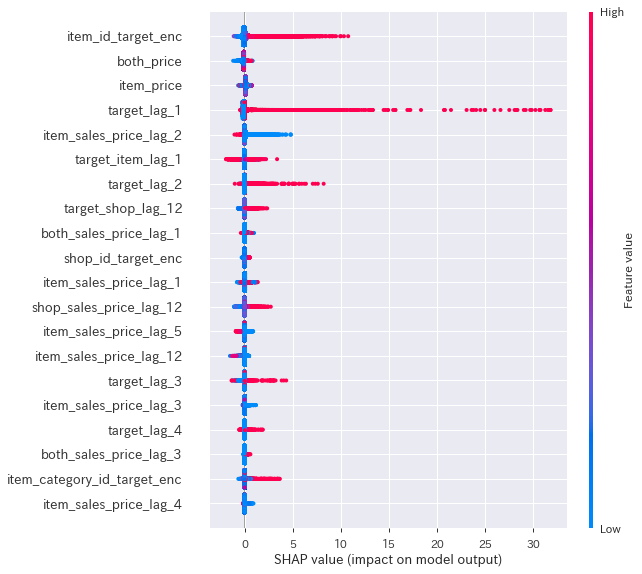

In [12]:
shap.summary_plot(shap_values, x_val)